In [1]:
# Now, each 2d bounding box has horizontal and vertical size. 
# Find the biggest horizontal (or vertical, it is up to you) size and 
# scale all the remaining 2d images so that all bounding boxes have the same horizontal (or vertical) size

# Next, calculate centers of mass for the rescaled images - do it in the same way as in the cell above.


# Then, define a fixed size image such that a biggest bounding box can be fit inside it 
# (so you must know both the biggest horizontal and vertical size among allbounding boxes
# but the rescaled bounding boxes will have the same only one size of the two: horizontal and vertical)


# Finally, generate fixed size images by inserting into them rescaled bounding boxes in such a way that centers of mass of each 
# bounding box is always in the same pixel of the fixes size image

# these images will be used for training VAE

# The procedure above is a simpistic variant of Procrustes analysis - please refer to e.g. https://en.wikipedia.org/wiki/Procrustes_analysis


In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import cv2
import json
import glob
import pydicom

import numpy as np
from PIL import Image

import nibabel as nib

import matplotlib.pyplot as plt

from skimage.transform import rescale

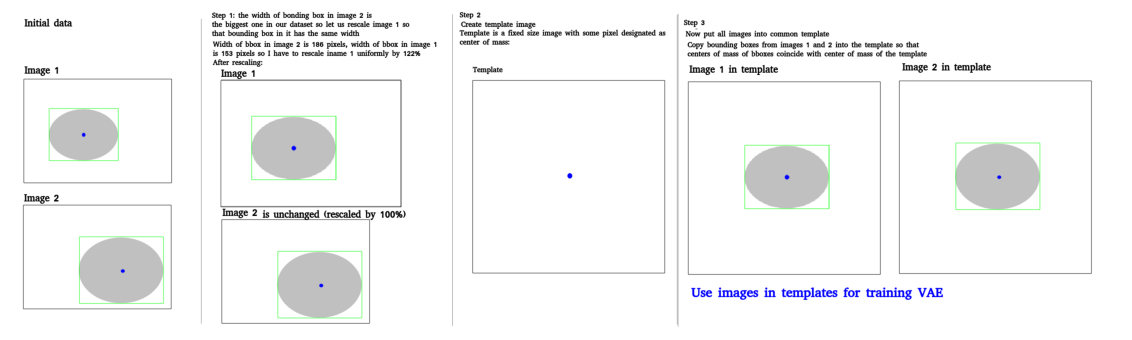

In [3]:
from matplotlib.pyplot import figure

figure(figsize=(18, 6), dpi=80)

Image1 = cv2.imread('instruction.png') 

plt.imshow(Image1) 
plt.axis('off') 
plt.show()

In [5]:
class reading_orignal_data:
    
    def __init__(self, MAIN_PATH,SUB_PATH={"CT_PATH":'/CT/',"RT_PATH":'/RTStruct/',}):

        self.INPUT_DIRECTORY = sorted(glob.glob(MAIN_PATH))
        self.PTV_IMAGES = []
        self.CT_SCAN_IMAGES = []

        for frakDir in self.INPUT_DIRECTORY: 

            ctDir     = frakDir + SUB_PATH["CT_PATH"]

            StructDicomFileName = glob.glob(frakDir+ SUB_PATH["RT_PATH"]+ '/*')[0]
            roiId=next((roi[0] for roi in self.displayStructureIDs(StructDicomFileName) if roi[1].lower() == "ptv"),None)
    
            if roiId !=None:
                _,ct = self.readDICOM3D(ctDir)
                cnt  = self.drawContours(ct.shape,roiId,ctDir,StructDicomFileName)

                cnt[cnt>0] = 1

                self.PTV_IMAGES.append(cnt)
                self.CT_SCAN_IMAGES.append(ct)

    def readDICOM3D(self,DICOM_DIR):
        dicomFiles = [file for file in os.listdir(DICOM_DIR) if file.endswith('dcm') and file.startswith('CT')]
        dicoms = []
        for file in dicomFiles:
            ds = pydicom.dcmread(DICOM_DIR+file)
            dicoms.append((DICOM_DIR+file,int(ds[0x0020,0x0013].value)))
        dicoms = sorted(dicoms, key=lambda x: x[1])

        im3D = []
        slicePositions = []
        for d in dicoms:
            ds = pydicom.dcmread(d[0])
            slicePositions.append(ds.ImagePositionPatient[2])
            im3D.append(ds.pixel_array)
    
        im3D = np.asarray(im3D,dtype=np.int16)
        im3D = np.swapaxes(im3D,0,1)
        im3D = np.swapaxes(im3D,1,2)

        ds = pydicom.dcmread(dicoms[0][0])
        CTOrigin = ds.ImagePositionPatient
        CTPixelSize = ds.PixelSpacing
        CTSliceThickness = ds.SliceThickness

        grid = (np.arange(CTOrigin[1],CTOrigin[1]+CTPixelSize[1]*im3D.shape[0],CTPixelSize[1]),
                np.arange(CTOrigin[0],CTOrigin[0]+CTPixelSize[0]*im3D.shape[1],CTPixelSize[0]),
                np.asarray(slicePositions,dtype=np.float64))
    
        return grid,im3D
    
    def displayStructureIDs(self,structuresFile):
        ROINumbers = []
        ds = pydicom.dcmread(structuresFile)
        for _,struct in enumerate(ds.StructureSetROISequence):
            ROINumbers.append((struct.ROINumber,struct.ROIName))
        return ROINumbers
    
    def drawContours(self,imSize,roiID,pathToCT,structuresDicomFileName):

        ds = pydicom.dcmread(structuresDicomFileName)

        roiNumbers = [dum.ROINumber for dum in ds.StructureSetROISequence]
        structID = roiNumbers.index(roiID)
    

        assert ds.SOPClassUID == "1.2.840.10008.5.1.4.1.1.481.3", "This is not a Dicom Structure file"

        ROI = [
            ds.ROIContourSequence[u].ContourSequence for u in range(len(ds.ROIContourSequence)) 
                if ds.ROIContourSequence[u].ReferencedROINumber == ds.StructureSetROISequence[structID].ROINumber
        ][0]

        positions = []
        CTs = glob.glob(pathToCT + '/CT*.dcm')
        for fname in CTs:
            ctds = pydicom.dcmread(fname)
            positions.append((ctds.ImagePositionPatient[2],fname)) 
            
        positions = sorted(positions, key=lambda x: x[0])  
        delta = positions[1][0] - positions[0][0]

        dum = np.zeros(imSize,dtype=np.uint8)
    
        for seq in ROI:
            points = np.swapaxes(np.reshape(seq.ContourData,(-1,3)),0,1)
            pos = points[2,0]
            for p in positions:
                if abs(pos - p[0]) < delta/2:
                    fname = p[1]     
            dicImage = pydicom.dcmread(fname)
        

            M = np.zeros((3,3),dtype = np.float32)
            M[0,0] = dicImage[0x0020, 0x0037].value[1]* dicImage[0x0028, 0x0030].value[0]
            M[1,0] = dicImage[0x0020, 0x0037].value[0]* dicImage[0x0028, 0x0030].value[0]
            M[0,1] = dicImage[0x0020, 0x0037].value[4]* dicImage[0x0028, 0x0030].value[1]
            M[1,1] = dicImage[0x0020, 0x0037].value[3]* dicImage[0x0028, 0x0030].value[1]
            M[0,2] = dicImage[0x0020, 0x0032].value[0]
            M[1,2] = dicImage[0x0020, 0x0032].value[1]
            M[2,2] = 1.0
        
            M = np.linalg.inv(M)
            points[2,:].fill(1)
            points = np.dot(M,points)[:2,:]

            big = int(ds.StructureSetROISequence[structID].ROINumber) # 255
            CTSlice = int(dicImage[0x0020,0x0013].value)-1            # numery sliców w Dicom startują od 1
            dum2D = np.zeros(imSize[0:2],dtype=np.uint8)
            for id in range(points.shape[1]-1):
                cv2.line(dum2D,(int(points[1,id]),int(points[0,id])),(int(points[1,id+1]),int(points[0,id+1])),big,1)
            cv2.line(dum2D,(int(points[1,points.shape[1]-1]),int(points[0,points.shape[1]-1])),(int(points[1,0]),int(points[0,0])),big,1)

            dum[dum2D!=0,CTSlice] = dum2D[dum2D!=0]
        
        for sl in range(dum.shape[2]):
            im_flood_fill = dum[...,sl].copy()
            h, w = dum.shape[:2]
            mask = np.zeros((h + 2, w + 2), np.uint8)
            im_flood_fill = im_flood_fill.astype("uint8")
            cv2.floodFill(im_flood_fill, mask, (0, 0), 128)
            dum[im_flood_fill!=128,sl] = big
        
        return dum
    
    @staticmethod
    def saveImage(PATH,LABEL,IMAGES):
        aff = np.eye(4)
        for INDEX,IMG in enumerate(IMAGES):
            baseName = PATH + LABEL + str(INDEX) + '_.nii.gz'
            niftiImage = nib.Nifti1Image(IMG, affine=aff)
            nib.save(niftiImage,baseName)
            
    def get_PTV_IMAGES(self):
        return self.PTV_IMAGES
    
    def get_CT_SCAN_IMAGES(self):
        return self.CT_SCAN_IMAGES

In [6]:
PTV_SAMPLES={}
for dir in next(os.walk('Samples/'))[1]:
    orignal_data_ob=reading_orignal_data(f'Samples/{dir}/frakcja_*')
    PTV_SAMPLES[dir]=orignal_data_ob.get_PTV_IMAGES()

In [7]:
def con_2d_image(binary_image):    
    
    center_of_mass=np.mean(np.where(binary_image),axis=1) 

    img_2d=binary_image[:,:,int(center_of_mass[2])]

    return img_2d

def calculate_image_detail (images_list,type=0):
    B2D_IMAGES={}
    B2D_CENTER={}
    B2D_SIZE={}
    B2D_START={}
    if type==0:
        for key, images in images_list.items():
            B2D_IMAGES[key]=[]
            B2D_CENTER[key]=[]
            B2D_SIZE[key]  =[]
            
            for single_image in images:
                img=con_2d_image(single_image.copy())
                
                one_location=np.where(img)
                B2D_CENTER[key].append(np.mean(one_location,axis=1).astype(np.int32))
                B2D_SIZE[key].append(tuple([np.max(one_location[i]) - np.min(one_location[i]) for i in range(2)]))
                B2D_IMAGES[key].append(img)
                
        return B2D_IMAGES, B2D_CENTER, B2D_SIZE
    else:
        for key, images in images_list.items():
            
            B2D_CENTER[key]=[]
            B2D_SIZE[key]  =[]
            B2D_START[key] =[]
            
            for single_image in images:
                one_location=np.where(single_image)
                
                B2D_CENTER[key].append(np.mean(one_location,axis=1).astype(np.int32))
                B2D_SIZE[key].append(
                    tuple([
                        np.max(one_location[i]) - np.min(one_location[i]) for i in range(2)
                ]))
                B2D_START[key].append(tuple([np.min(one_location[i]) for i in range(2)]))
        return B2D_CENTER, B2D_SIZE,B2D_START

# Step 1

Each 2d bounding box has horizontal and vertical size. Find the biggest horizontal (or vertical, it is up to you) size and scale all the remaining 2d images so that all bounding boxes have the same horizontal (or vertical) size

In [8]:
BINARY_2D_IMAGES, BINARY_2D_CENTER, BINARY_2D_SIZE= calculate_image_detail(PTV_SAMPLES,0)

In [10]:
# MAX_X=np.max(BINARY_2D_SIZE[0:24],axis=0)[1]

# for size,im in zip(BINARY_2D_SIZE[0:24],BINARY_2D_IMAGES["Pacjent_02_anonymized"]):
    
#     scaling = MAX_X/size[1]
    
#     rescaled = rescale(im,scaling, anti_aliasing=False,preserve_range=True,order=0)
    
#     locs = np.where(rescaled)
#     newsize = [np.max(l)-np.min(l) for l in locs]
#     # print(im.shape,size,rescaled.shape,newsize)
    

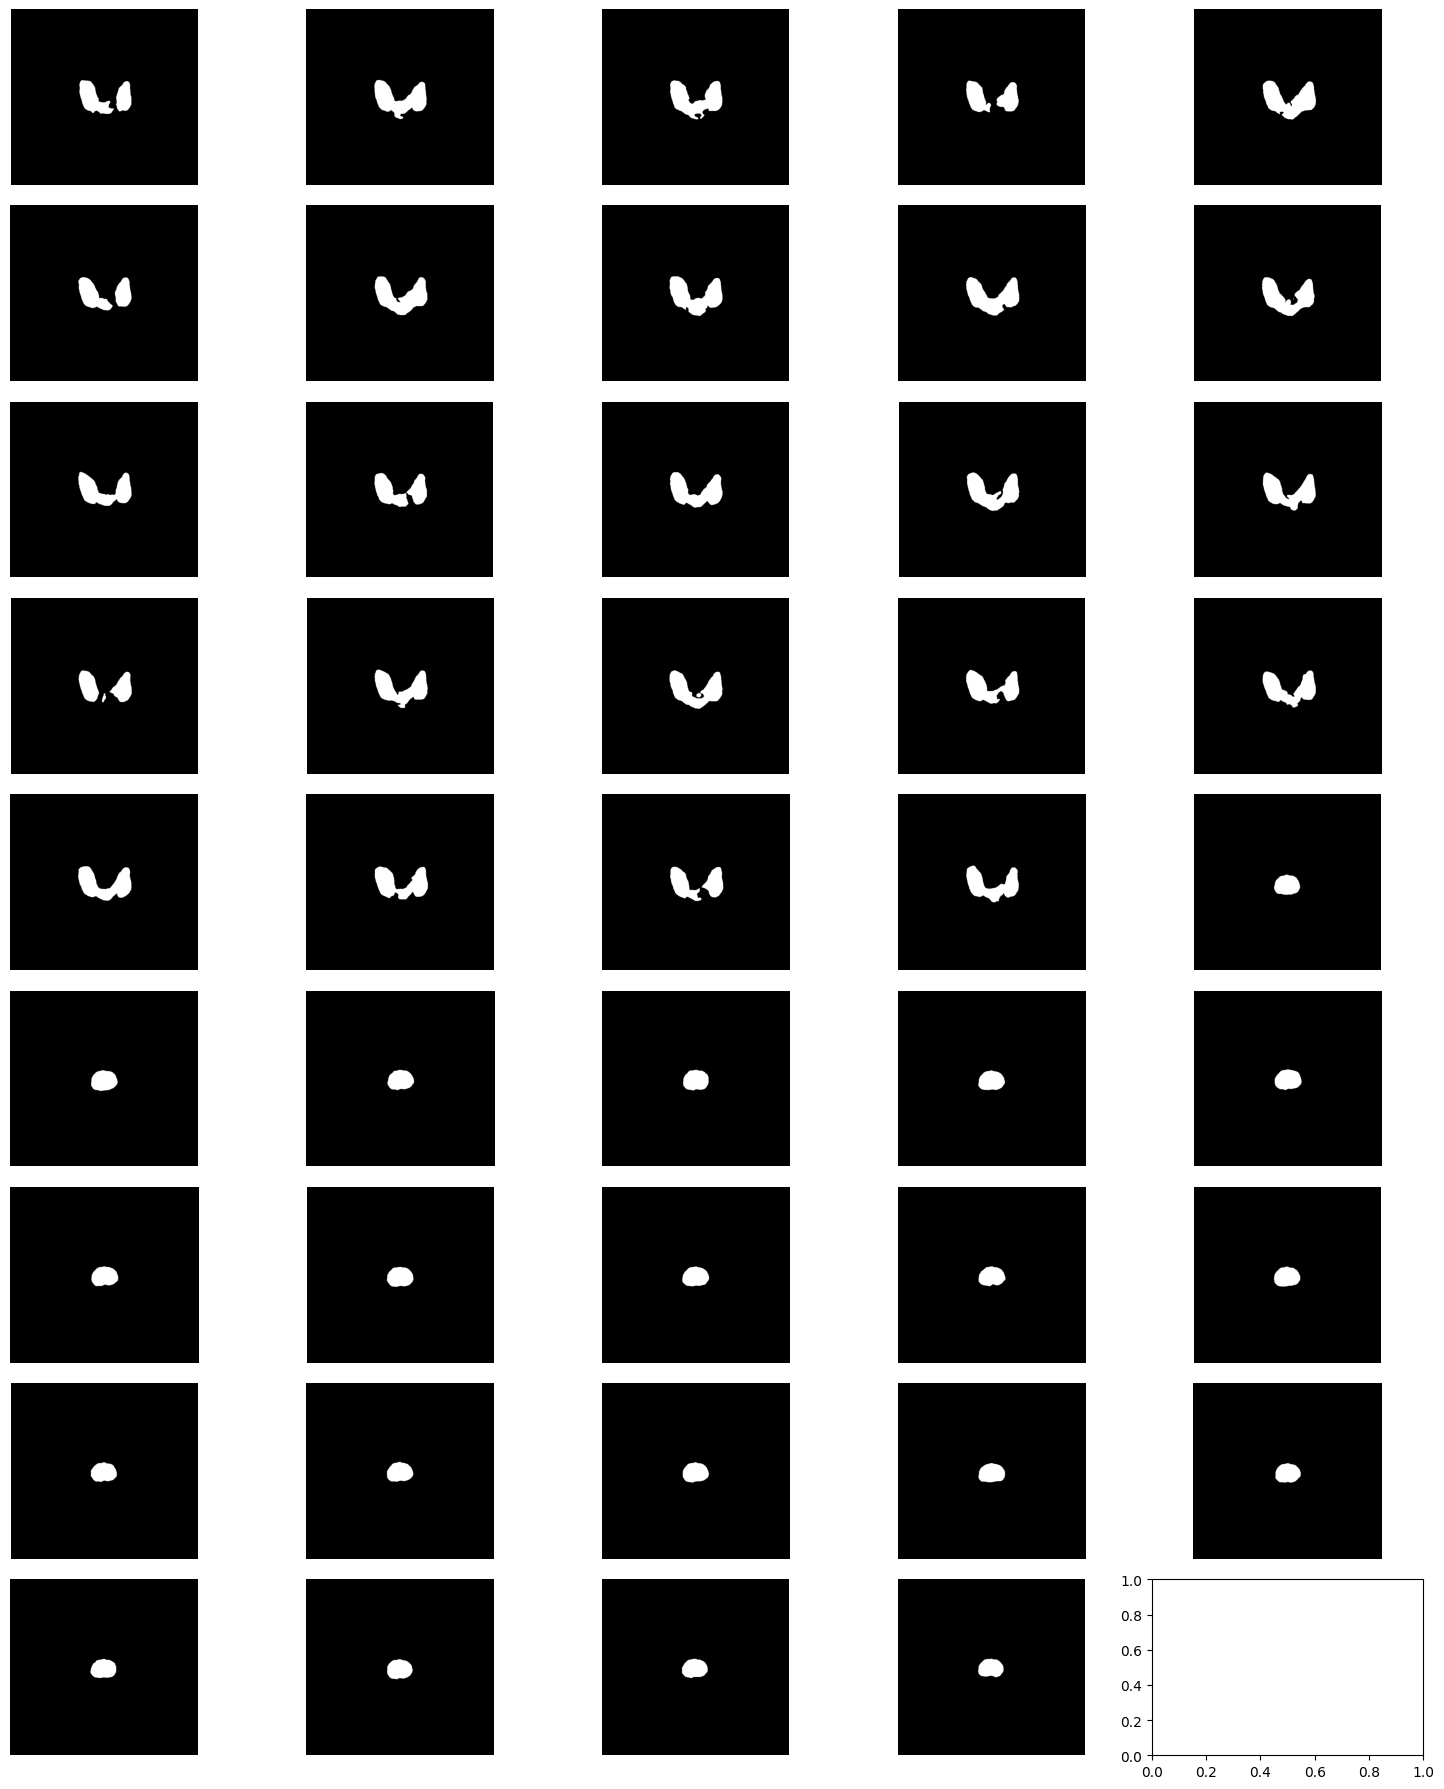

In [12]:
fig, axs = plt.subplots(9,5,figsize=(15,18))

NEW_BINARY_2D_IMAGES={}

index=0
for key in BINARY_2D_IMAGES.keys():
    
    MAX_X=np.max(BINARY_2D_SIZE[key],axis=0)[1]
    
    NEW_BINARY_2D_IMAGES[key]=[]
    for (size,img) in zip(BINARY_2D_SIZE[key],BINARY_2D_IMAGES[key]):
        ax=axs.flat[index]
        
        img = rescale(img, MAX_X/size[1], anti_aliasing=False,preserve_range=True,order=0)
        
    #     # locs = np.where(img)
    #     # print([np.max(l)-np.min(l) for l in locs])
        
        NEW_BINARY_2D_IMAGES[key].append(img)
        
        ax.imshow(img,cmap="gray")
        ax.axis("off")
        index+=1
    
# fig.delaxes(axs[8][4])
fig.tight_layout()

# Step 2

In [28]:
# Next, calculate centers of mass for the rescaled images - do it in the same way as in the cell above.
NEW_BINARY_2D_CENTER, NEW_BINARY_2D_SIZE,NEW_BINARY_YX_START= calculate_image_detail(NEW_BINARY_2D_IMAGES,1)

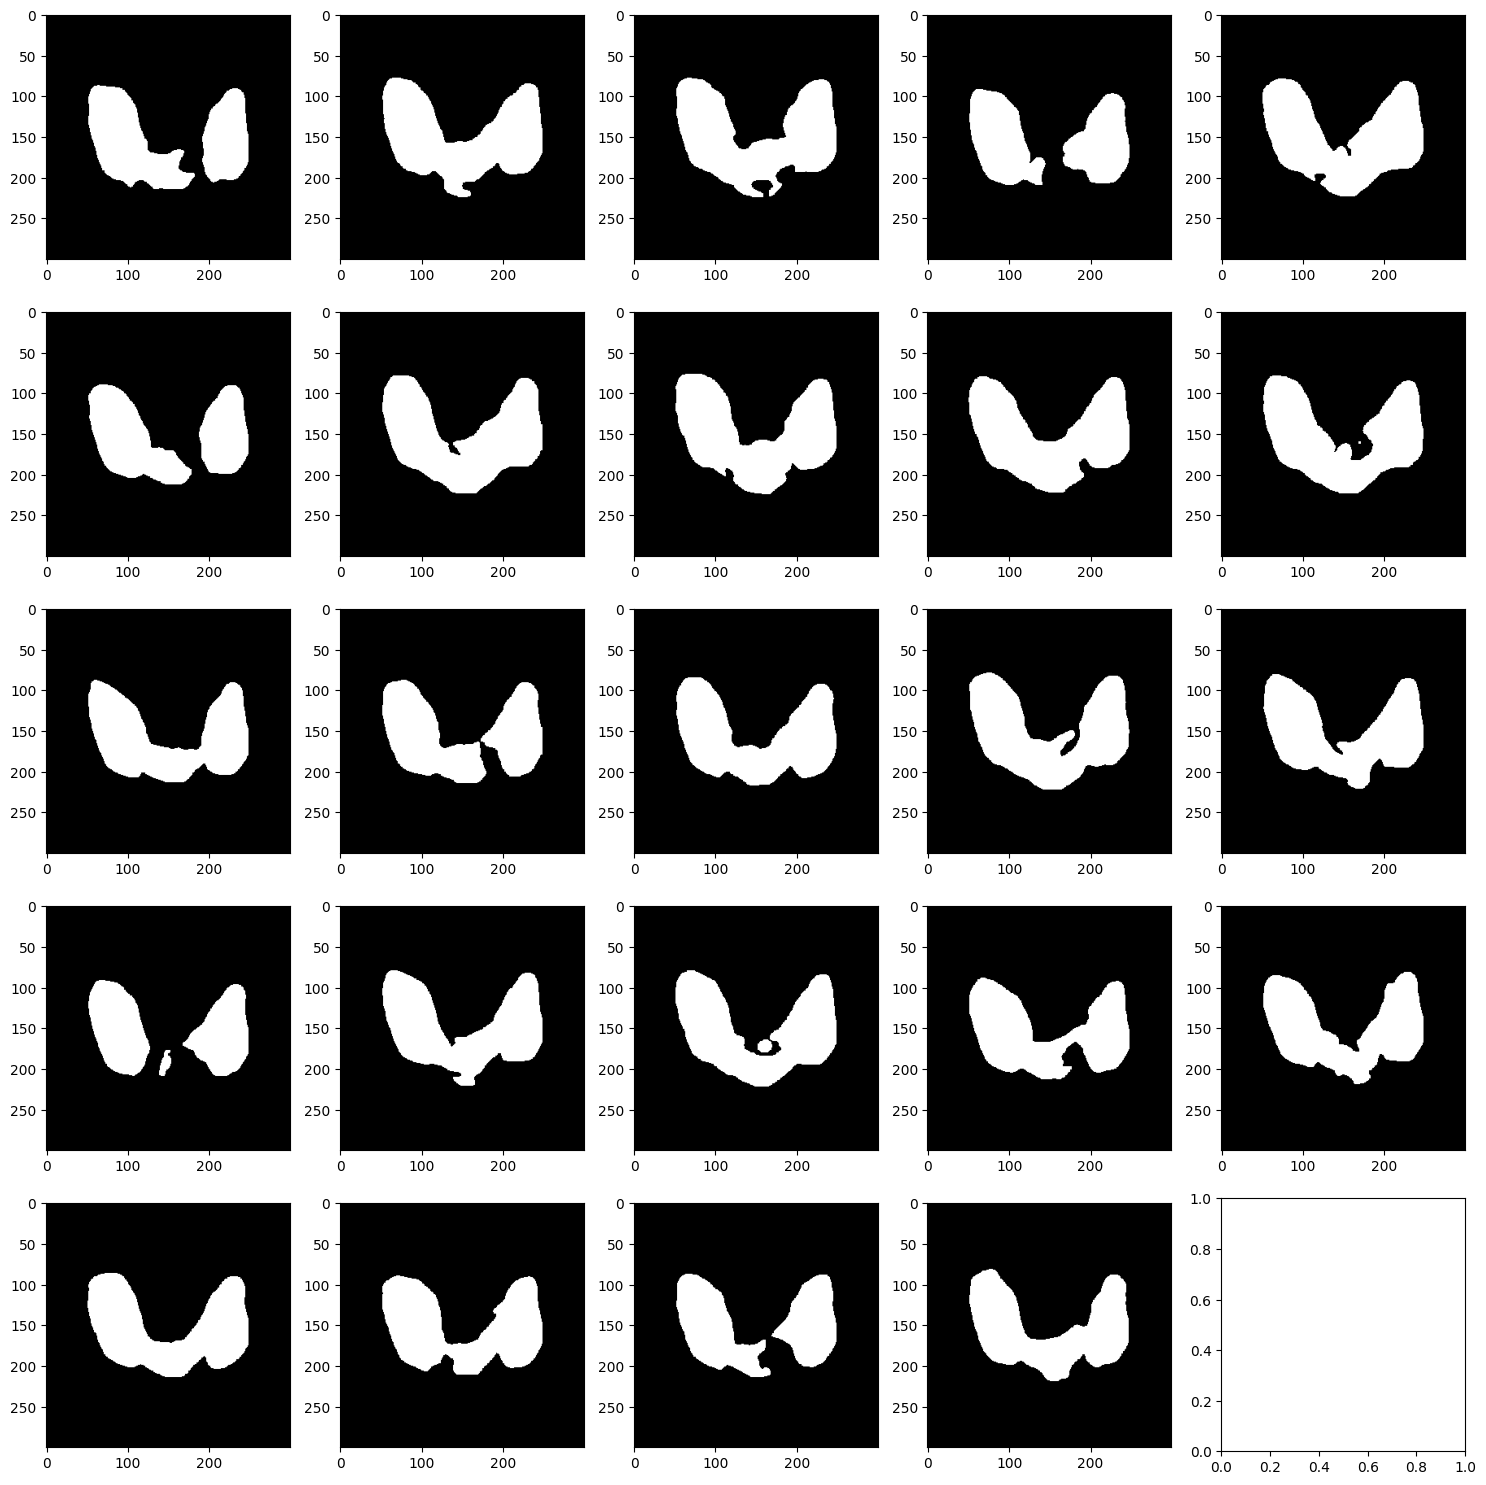

In [65]:
patient_key="Pacjent_02_anonymized"

# template shape
# TEM_H,TEM_W=np.max([img.shape for img in NEW_BINARY_2D_IMAGES[patient_key]],axis=0)
TEM_H,TEM_W=(300,300)

# center of the template
# TEM_Y_CENTER,TEM_X_CENTER=np.mean(NEW_BINARY_2D_CENTER[patient_key],axis=0).astype(np.int32)
TEM_Y_CENTER,TEM_X_CENTER=150, 150


#final output
FINAL_BINARY_2D_IMAGES=[]

fig, axs = plt.subplots(5,5,figsize=(15,15))

for index,image in enumerate(NEW_BINARY_2D_IMAGES[patient_key]):
    
    ax=axs.flat[index]

    #bring the image from current image
    object=image[
        NEW_BINARY_YX_START[patient_key][index][0]:
        NEW_BINARY_YX_START[patient_key][index][0]+NEW_BINARY_2D_SIZE[patient_key][index][0], 
        NEW_BINARY_YX_START[patient_key][index][1]:
        NEW_BINARY_YX_START[patient_key][index][1]+NEW_BINARY_2D_SIZE[patient_key][index][1]
    ]
    
    # #define template
    new_image = np.zeros((TEM_H,TEM_W), dtype=int)
    
    # #find y,x start of for the object in the template
    new_y_start,new_x_start=(
        TEM_Y_CENTER-int(object.shape[0]/2),
        TEM_X_CENTER-int(object.shape[1]/2)
    ) 
        
    # # add the object to the template
    new_image[new_y_start:new_y_start+object.shape[0], new_x_start:new_x_start+object.shape[1]] = object

    FINAL_BINARY_2D_IMAGES.append(new_image)


    ax.imshow(new_image,cmap="gray")
    plt.imsave(f'data/{patient_key}/{index}.png', new_image, cmap="binary")

    
fig.tight_layout()
fig.show()

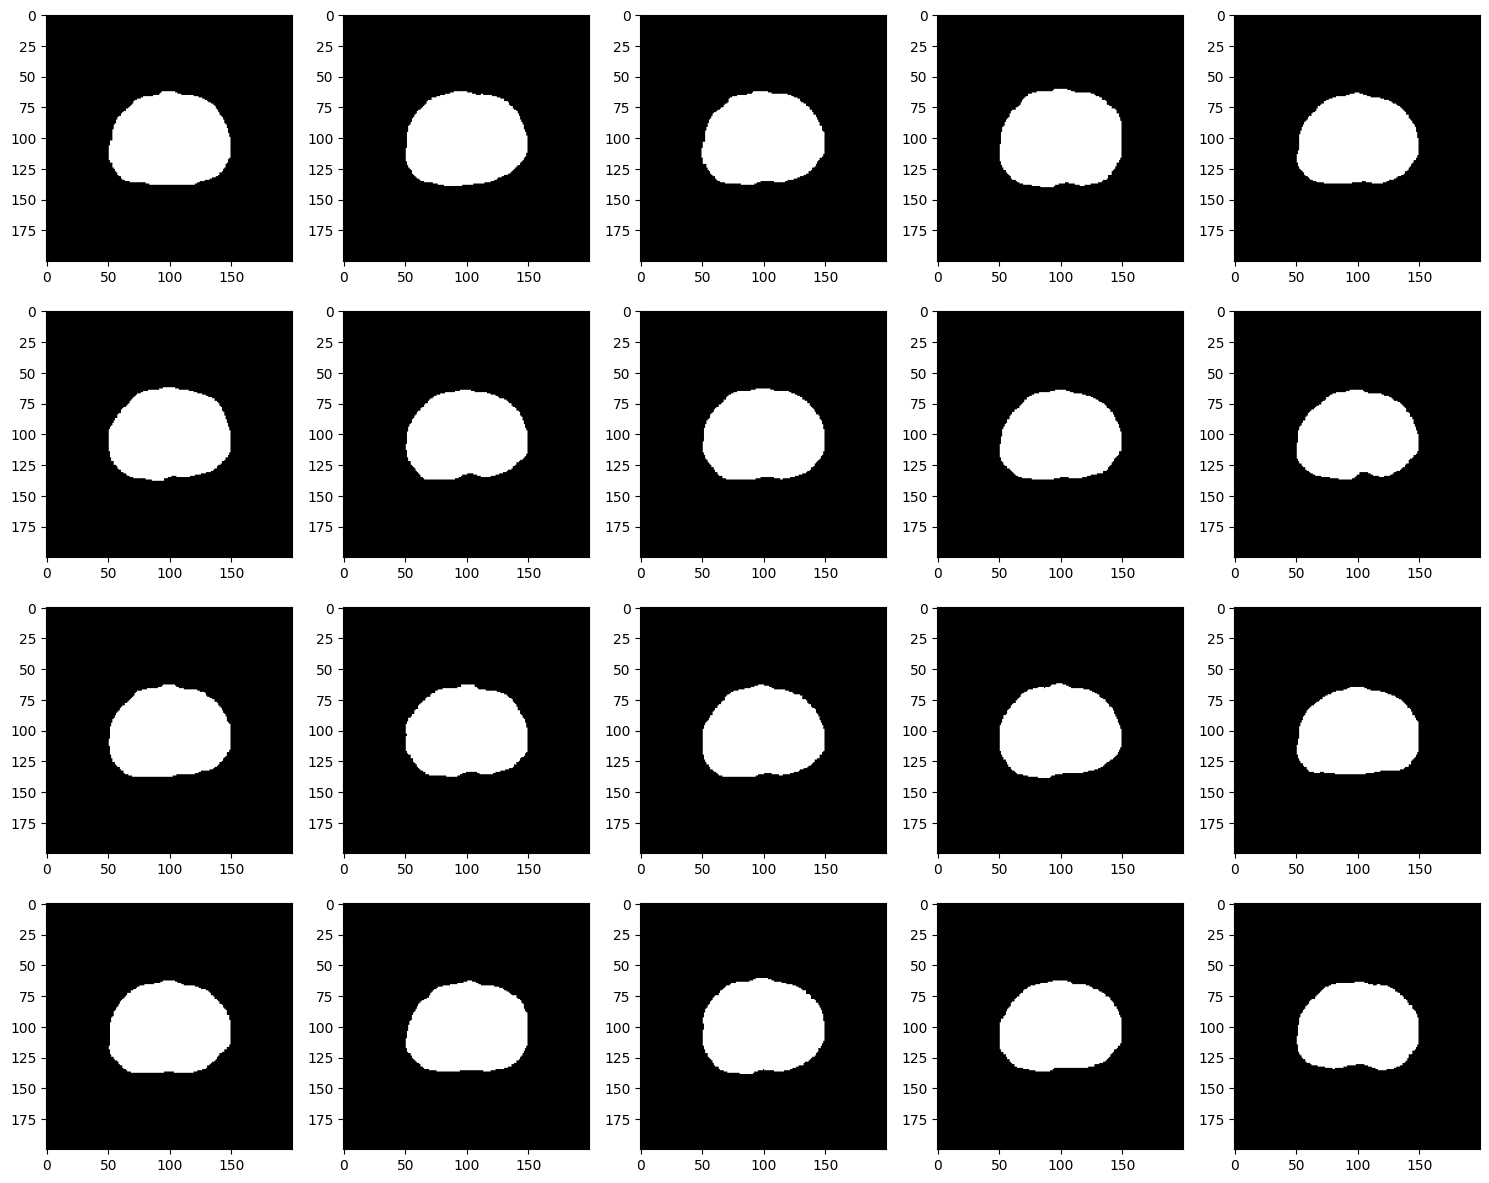

In [66]:
patient_key="Pacjent_01_anonymized"

# template shape
# TEM_H,TEM_W=np.max([img.shape for img in NEW_BINARY_2D_IMAGES[patient_key]],axis=0)
TEM_H,TEM_W=(200,200)

# center of the template
# TEM_Y_CENTER,TEM_X_CENTER=np.mean(NEW_BINARY_2D_CENTER[patient_key],axis=0).astype(np.int32)
TEM_Y_CENTER,TEM_X_CENTER=100, 100


#final output
FINAL_BINARY_2D_IMAGES=[]

fig, axs = plt.subplots(4,5,figsize=(15,12))

for index,image in enumerate(NEW_BINARY_2D_IMAGES[patient_key]):
    
    ax=axs.flat[index]

    #bring the image from current image
    object=image[
        NEW_BINARY_YX_START[patient_key][index][0]:
        NEW_BINARY_YX_START[patient_key][index][0]+NEW_BINARY_2D_SIZE[patient_key][index][0], 
        NEW_BINARY_YX_START[patient_key][index][1]:
        NEW_BINARY_YX_START[patient_key][index][1]+NEW_BINARY_2D_SIZE[patient_key][index][1]
    ]
    
    # #define template
    new_image = np.zeros((TEM_H,TEM_W), dtype=int)
    
    # #find y,x start of for the object in the template
    new_y_start,new_x_start=(
        TEM_Y_CENTER-int(object.shape[0]/2),
        TEM_X_CENTER-int(object.shape[1]/2)
    ) 
        
    # # add the object to the template
    new_image[new_y_start:new_y_start+object.shape[0], new_x_start:new_x_start+object.shape[1]] = object

    FINAL_BINARY_2D_IMAGES.append(new_image)


    ax.imshow(new_image,cmap="gray")
    plt.imsave(f'data/{patient_key}/{index}.png', new_image, cmap="binary")
    
    
fig.tight_layout()
fig.show()

# New Samples

In [3]:
def show_polt(img_list,shape=(1,1),size=(5,5)):
    fig, axs = plt.subplots(shape[0],shape[1],figsize=size)

    index=0
    for index,image in enumerate(img_list):
        
        
        ax=axs.flat[index]        
            
            
        ax.imshow(image,cmap="gray")
        ax.axis("off")
        
    # fig.delaxes(axs[8][4])
    fig.tight_layout()

In [4]:
NEW_PTV_SAMPLES={}

In [5]:
NEW_PTV_SAMPLES["bladder"]=[]
for path in glob.glob("../input/bladder/*"):
    
    nii_img  = nib.load(f'{path}')
    nii_data = nii_img.get_fdata()
    
    NEW_PTV_SAMPLES["bladder"].append(nii_data)
    
NEW_PTV_SAMPLES["prostate"]=[]
for path in glob.glob("../input/prostate/*"):
    
    nii_img  = nib.load(f'{path}')
    nii_data = nii_img.get_fdata()
    
    NEW_PTV_SAMPLES["prostate"].append(nii_data)

In [8]:
BINARY_2D_IMAGES, BINARY_2D_CENTER, BINARY_2D_SIZE= calculate_image_detail(NEW_PTV_SAMPLES,0)

In [13]:
BINARY_2D_IMAGES["bladder"][0].shape

(512, 512)

In [9]:
NEW_BINARY_2D_IMAGES={}

for key in BINARY_2D_IMAGES.keys():
    
    MAX_X=np.max(BINARY_2D_SIZE[key],axis=0)[1]
    
    NEW_BINARY_2D_IMAGES[key]=[]
    for (size,img) in zip(BINARY_2D_SIZE[key],BINARY_2D_IMAGES[key]):
        
        img = rescale(img, MAX_X/size[1], anti_aliasing=False,preserve_range=True,order=0)
        
    #     # locs = np.where(img)
    #     # print([np.max(l)-np.min(l) for l in locs])
        
        NEW_BINARY_2D_IMAGES[key].append(img)

In [10]:
NEW_BINARY_2D_CENTER, NEW_BINARY_2D_SIZE,NEW_BINARY_YX_START= calculate_image_detail(NEW_BINARY_2D_IMAGES,1)

In [15]:
FINAL_BINARY_2D_IMAGES={}


for patient_key in NEW_BINARY_2D_IMAGES.keys():
    
    # if patient_key=="bladder":
    TEM_H,TEM_W=(240,240)
    TEM_Y_CENTER,TEM_X_CENTER=120, 120
    # else:
        # TEM_H,TEM_W=(200,200)
        # TEM_Y_CENTER,TEM_X_CENTER=100, 100
    
    FINAL_BINARY_2D_IMAGES[patient_key]=[]
    for index,image in enumerate(NEW_BINARY_2D_IMAGES[patient_key]):
        # print(patient_key,image.shape)

        #bring the image from current image
        object=image[
            NEW_BINARY_YX_START[patient_key][index][0]:
            NEW_BINARY_YX_START[patient_key][index][0]+NEW_BINARY_2D_SIZE[patient_key][index][0], 
            NEW_BINARY_YX_START[patient_key][index][1]:
            NEW_BINARY_YX_START[patient_key][index][1]+NEW_BINARY_2D_SIZE[patient_key][index][1]
        ]
        new_image = np.zeros((TEM_H,TEM_W), dtype=int)
        
        # #find y,x start of for the object in the template
        new_y_start,new_x_start=(
            TEM_Y_CENTER-int(object.shape[0]/2),
            TEM_X_CENTER-int(object.shape[1]/2)
        ) 
        # # add the object to the template
        new_image[new_y_start:new_y_start+object.shape[0], new_x_start:new_x_start+object.shape[1]] = object

        FINAL_BINARY_2D_IMAGES[patient_key].append(new_image)
        
        
        new_image = Image.fromarray(new_image.astype(np.uint8) * 255)
        new_image.save(f'../data/train/{patient_key}/{index}.png')


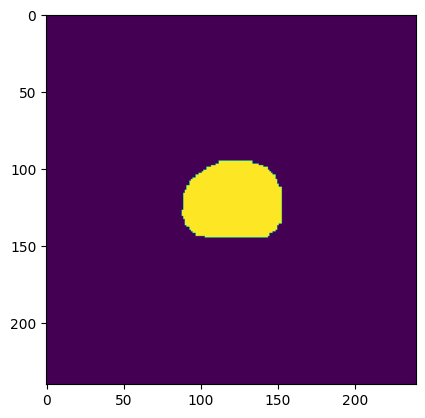

In [16]:
img  = plt.imread(f'../data/train/{patient_key}/{index}.png')

plt.imshow(img)

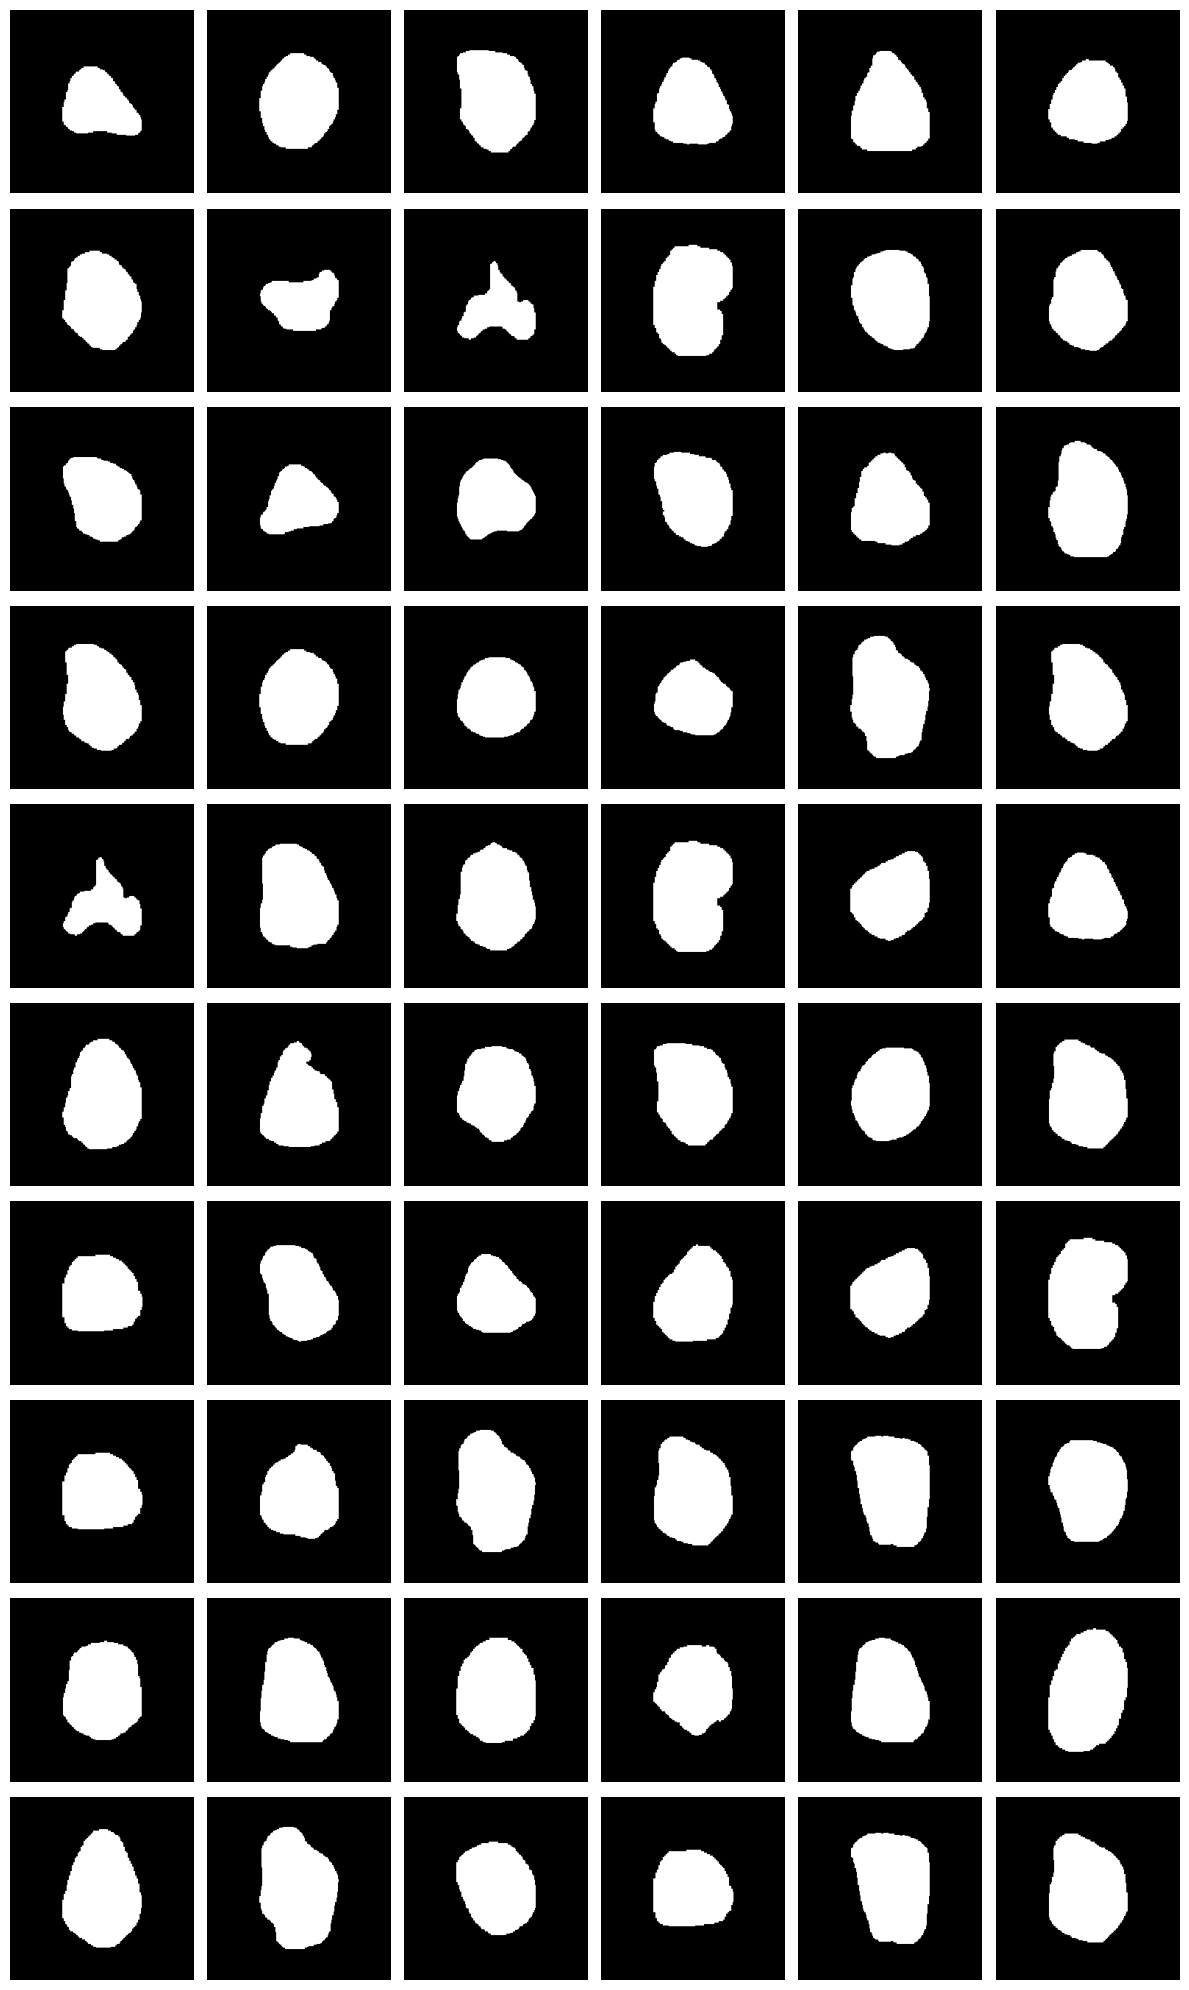

In [13]:
show_polt(FINAL_BINARY_2D_IMAGES["bladder"],(10,6),(12,20))

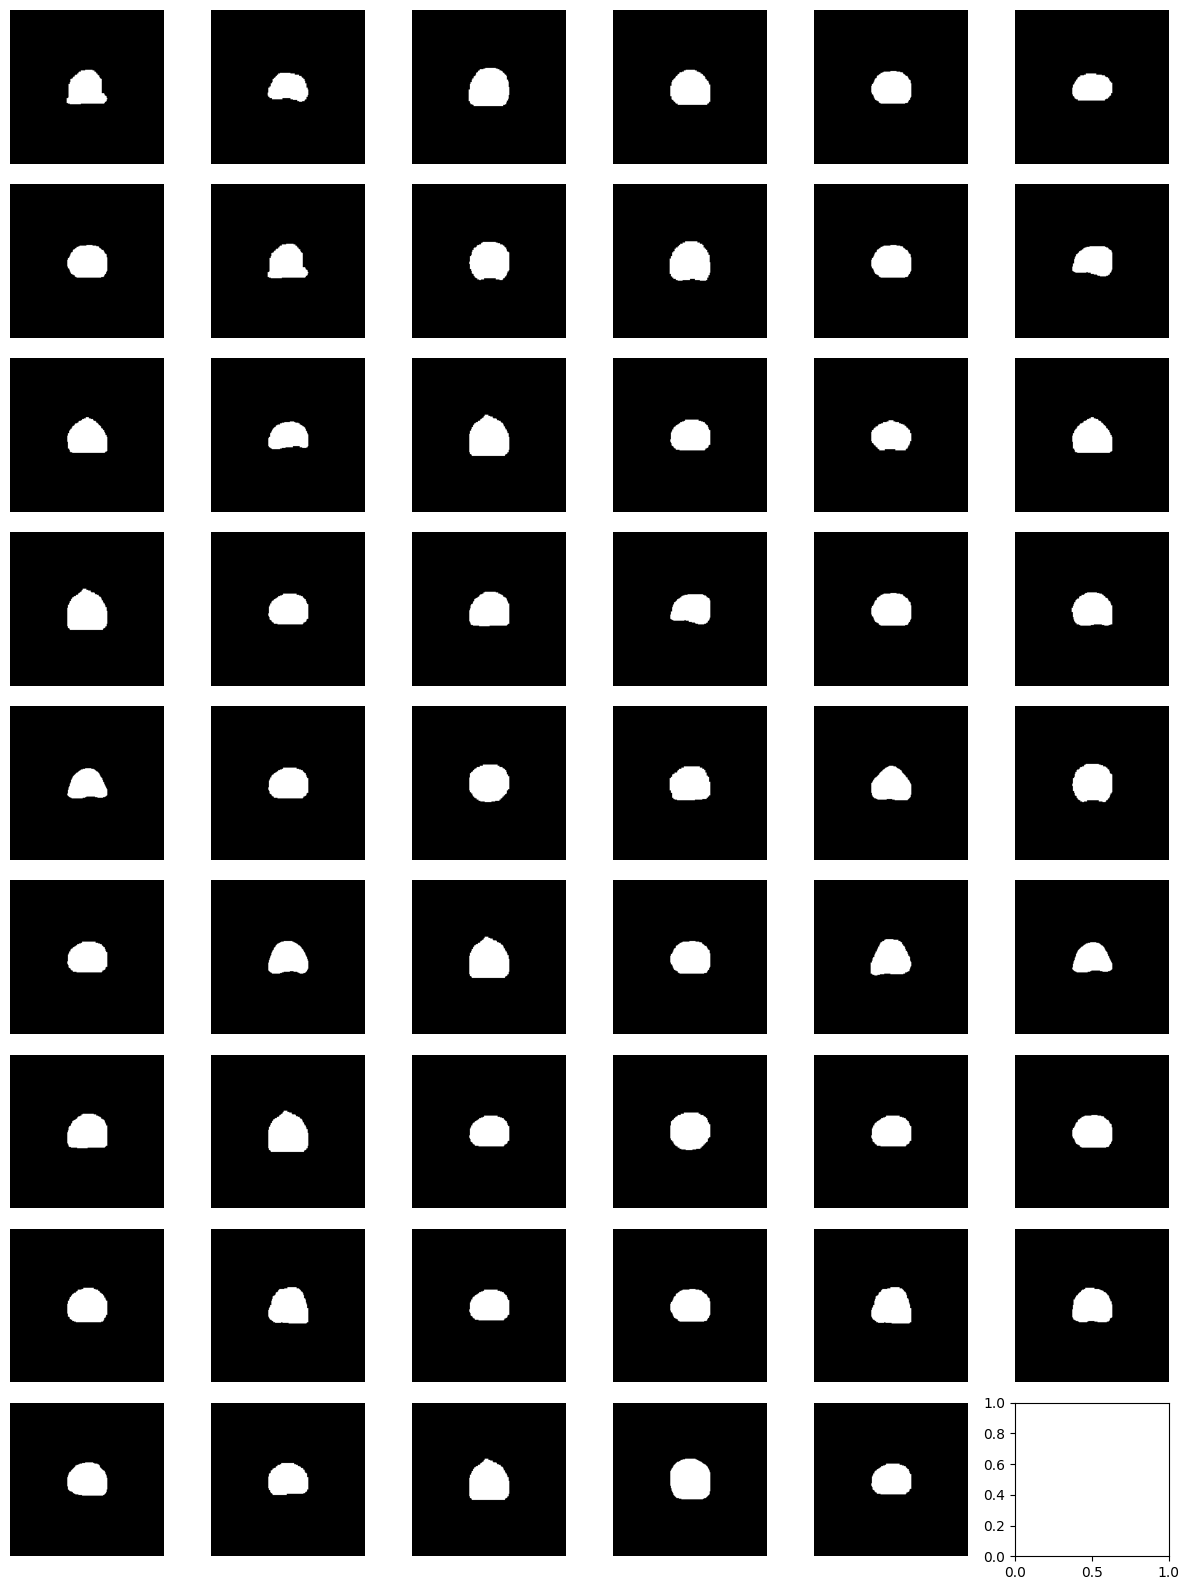

In [14]:
show_polt(FINAL_BINARY_2D_IMAGES["prostate"],(9,6),(12,16))
